### This is a notebook that illustrates some of the concepts from the Mihalas Section 14: Radiative Transfer in Moving Atmospheres 


#### First we are convincing ourselves about some basic stuff, using observer's frame, and casting radiative transfer equation in terms of reduced frequency x, direction and optical depth. 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

In [25]:
def solve_RTE(tau, S):

    ND = len(tau)
    I = np.zeros(ND)  # initialize the intensity
    # Lower boundary condition: 
    I[-1] = S[-1]  # intensity at the bottom of the atmosphere is equal to the source function at the bottom of the atmosphere

    for d in range(ND-2, -1, -1):

        deltatau = tau[d+1] - tau[d]
        if (deltatau < 0):
            deltatau = 0.0  # to avoid negative optical depths
        
        if (deltatau < 1e-3):
            # Use Taylor expansion for small optical depths
            S_mean = 0.5 * (S[d+1] - S[d])
            I[d] = I[d+1] * (1 - deltatau) + S_mean * deltatau
            continue
        else:
            S_mean = 0.5 * (S[d+1] + S[d])
            I[d] = I[d+1] * np.exp(-deltatau) + S_mean * (1 - np.exp(-deltatau))

    return I

In [10]:
# Define grid of reduced wavelengths: 
NL = 71
x = np.linspace(-7,7,71)

ND = 101
# Define spatial grid in tau
# Note that this tau is MEAN TAU IN THE LINE. We convert it to tau(x) by multiplying with phi(x) and later with (phi(x)+r)
logtau = np.linspace(-5,5,ND)
tau = 10**logtau

# Define source function, consider it given we are not talking about non-LTE here!
# For example we take linear source function with log tau
S = 0.2 + (logtau+5)/5

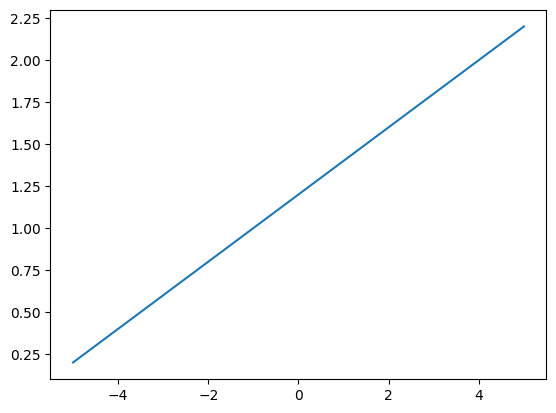

In [7]:
# Test plot the source function:
plt.plot(logtau,S)

In [9]:
# Let's test if we can get emergent intensity at line center and in the continuum
phi_static = (1/np.sqrt(np.pi))*np.exp(-x**2)  # Gaussian line profile

In [11]:
spectrum = np.zeros(NL)
for l in range(NL):
    phi = phi_static[l]
    tau_x = tau * (phi)
    I = solve_RTE(tau_x, S)
    spectrum[l] = I[0]  # emergent intensity at the top of the atmosphere   

Text(0.5, 1.0, 'Emergent line profile')

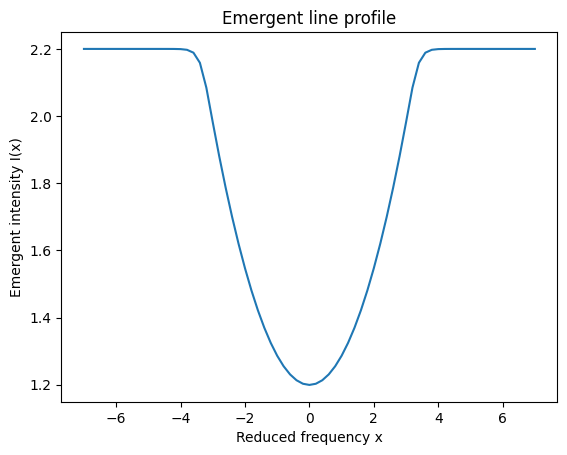

In [12]:
# Make a plot to test: 
plt.plot(x, spectrum)
plt.xlabel("Reduced frequency x")
plt.ylabel("Emergent intensity I(x)")
plt.title("Emergent line profile")

In [17]:
# Let's now see what happens when we have doppler shifts due to velocity fields.

def calc_phi(x, mu, V):
    # V is in units of doppler width
    xprim = x - mu*V
    return (1/np.sqrt(np.pi)) * np.exp(-xprim**2)

In [14]:
# For the first test, V is constant and positive, for example: 
V = np.ones(ND) * 2.0  # velocity in units of doppler width

In [18]:
# Now do the formal solution:

mu = 1.0
spectrum = np.zeros(NL)
for l in range(NL):
    phi = calc_phi(x[l], mu, V)
    tau_x = tau * phi
    I = solve_RTE(tau_x, S)
    spectrum[l] = I[0]  # emergent intensity at the top of the atmosphere   

Text(0.5, 1.0, 'Emergent line profile')

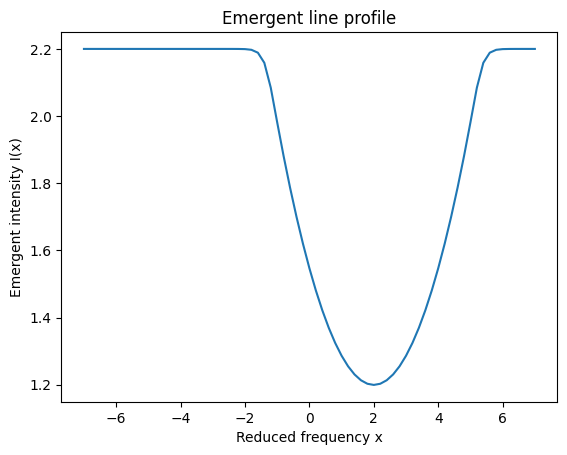

In [19]:
# Make a plot to test: 
plt.plot(x, spectrum)
plt.xlabel("Reduced frequency x")
plt.ylabel("Emergent intensity I(x)")
plt.title("Emergent line profile")

#### Don't be confused - this is indeed a blue shift *Because we are working in units of frequency!!!*

#### To make things less awkward, let's write a small function, that transforms x into actual wavelength for given $\Delta \lambda_D$

In [20]:
def convert_x_to_lambda(x, lambda0, delta_lambda_D):
    lambda_vals = lambda0 - x * delta_lambda_D
    return lambda_vals

Text(0.5, 1.0, 'Emergent line profile')

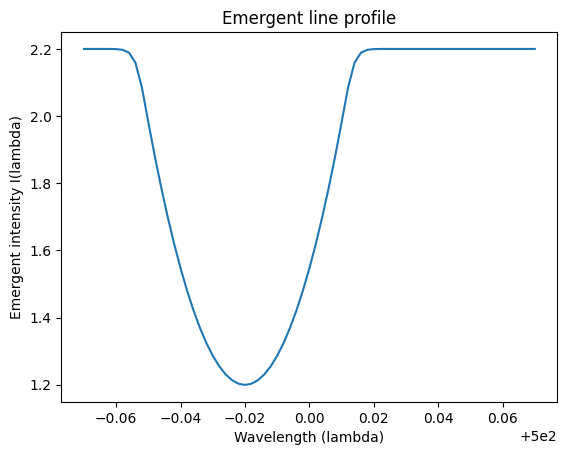

In [21]:
# Make a plot to test: 
lambda_vals = convert_x_to_lambda(x, 500.0, 0.01)  # example values
plt.plot(lambda_vals, spectrum)
plt.xlabel("Wavelength (lambda)")
plt.ylabel("Emergent intensity I(lambda)")
plt.title("Emergent line profile")

#### So far so good - now let's see what happens when we have a velocity gradient!

In [46]:
V = np.linspace(-3,3,ND)  # velocity in units of doppler width
V[:] = 0.0

In [32]:
# Good to have a function that solves the whole spectrum synthesis for given V and mu: 
def synthesize_spectrum(S, tau, V, mu):
    spectrum = np.zeros(NL)
    for l in range(NL):
        phi = calc_phi(x[l], mu, V)
        tau_x = tau * phi
        I = solve_RTE(tau_x, S)
        spectrum[l] = I[0]  # emergent intensity at the top of the atmosphere   
    return spectrum

def synthesize_full_intensity(S, tau, V, mu):
    ND = len(S)
    full_intensity = np.zeros([ND,NL])
    for l in range(NL):
        phi = calc_phi(x[l], mu, V)
        tau_x = tau * phi
        I = solve_RTE(tau_x, S)
        full_intensity[:, l] = I  # store the full intensity profile for each wavelength
    return full_intensity

In [30]:
spectrum = synthesize_spectrum(S, tau, V, 1.0)

Text(0.5, 1.0, 'Emergent line profile')

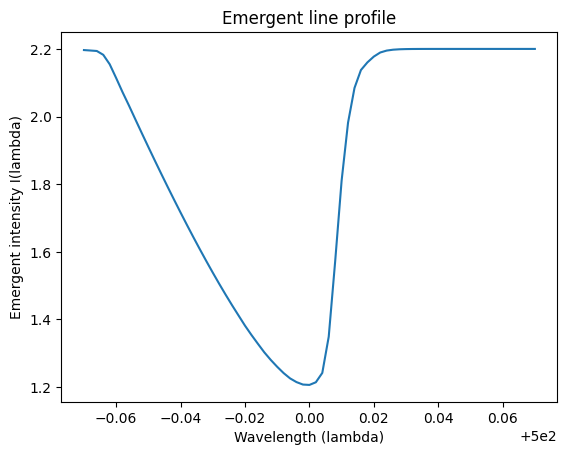

In [31]:
# Make a plot to test: 
lambda_vals = convert_x_to_lambda(x, 500.0, 0.01)  # example values
plt.plot(lambda_vals, spectrum)
plt.xlabel("Wavelength (lambda)")
plt.ylabel("Emergent intensity I(lambda)")
plt.title("Emergent line profile")

In [47]:
I_full = synthesize_full_intensity(S, tau, V, 1.0)
phi_full = calc_phi(x[None,:], 1.0, V[:, None])  # broadcasting to get phi for all x and depths

In [48]:
print(I_full.shape)
print(phi_full.shape)


(101, 71)
(101, 71)


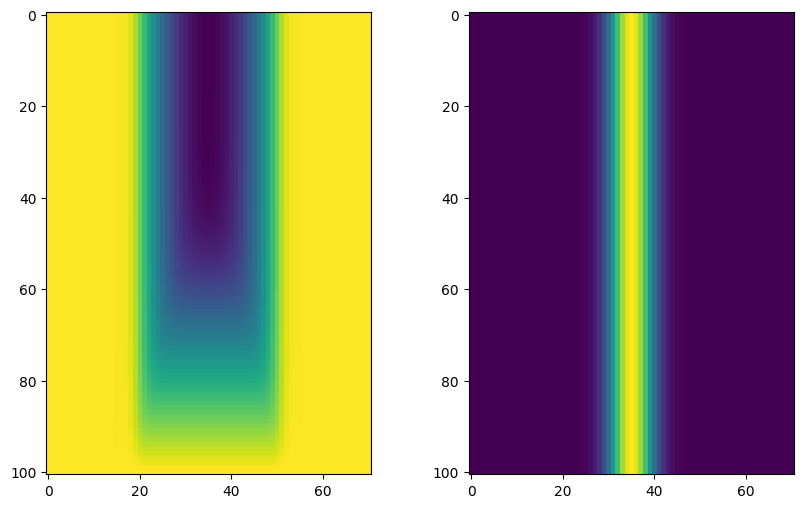

In [ ]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(I_full, extent=[x[0], x[-1], logtau[0], logtau[-1]], aspect='auto')
plt.subplot(1,2,2)
plt.imshow(phi_full)